# pymc3 vs pyro

My first inference with pymc3 and pyro.

Let's simulate some data first.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

p = 0.7

#simulate the data
y = np.random.binomial(20,p, size=100 )

In [23]:
import pymc3 as pm

with pm.Model() as bern_model:
    #priors
    theta = pm.Beta("prob", alpha=2, beta=2)
    #likelihood
    y_observed = pm.Binomial(
        "y_observed",
        n=20,
        p=theta,
        observed=y
    )
    prior = pm.sample_prior_predictive()
    posterior = pm.sample(500)
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prob]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 3032.67draws/s]


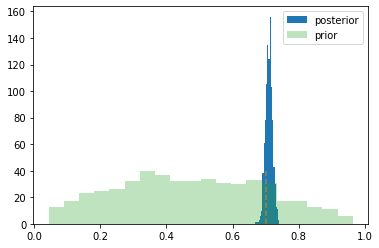

In [24]:
fig, ax = plt.subplots()
ax.hist(posterior['prob'], bins=20, label='posterior')
ax.plot([p]*2, [0,40], linestyle='dashed',alpha=0.6)
ax.hist(prior['prob'],bins =20, label='prior', alpha = 0.3)
plt.legend()
plt.show()

/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<AxesSubplot:title={'center':'prob'}>,
        <AxesSubplot:title={'center':'prob'}>]], dtype=object)

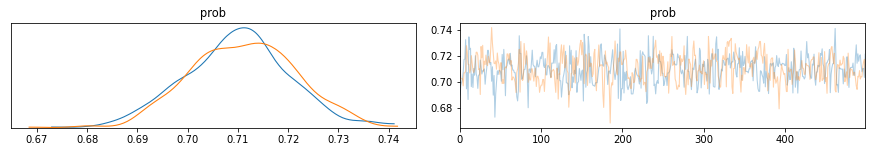

In [27]:
import arviz as az
az.plot_trace(posterior)

In [28]:
az.summary(posterior)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prob,0.71,0.01,0.69,0.729,0.0,0.0,460.0,459.0,460.0,630.0,1.01


array([<AxesSubplot:title={'center':'prob'}>], dtype=object)

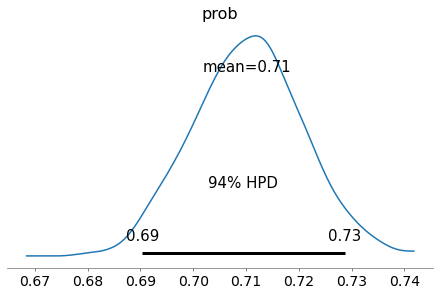

In [29]:
az.plot_posterior(posterior)

# pyro

Now let's try the same simple model but in the new [pyro](https://pyro.ai/).

In [72]:
import pyro

def obs_in_group(p=0.7):
    #This is how you can sample from a pyro distribution
    obs = pyro.sample("y_obs", pyro.distributions.Binomial(20,p))
    return obs.item()


In [73]:
#plate is construct for conditionally independent sequences of variables, 
# returns a A reusabe context manager yielding a single 1-dimensional torch.Tensor of indices.
def model(y,n=20):
    """
    Define the likelihood and the data input, state the priors
    """
    p = pyro.sample("p", pyro.distributions.Beta(2,2)) #prior
    with pyro.plate("data",len(y)):
        #likelihood and data statement
        pyro.sample("obs",pyro.distributions.Binomial(n,p), obs=y)


In [74]:
from pyro.infer import MCMC, NUTS
import torch

y_tensor = torch.tensor(y, dtype=torch.float) #everything must be tensors
nuts_kernel = NUTS(model) #initialise sampler

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200) #initialise mcmc object
mcmc.run(y_tensor) #args feed into model args

Sample: 100%|██████████| 1200/1200 [00:06, 171.47it/s, step size=7.56e-01, acc. prob=0.943]


In [75]:
hmc_samples = {
    k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()
}

Site: p
       mean       std        5%       25%       50%       75%       95%
0  0.694311  0.010004  0.677751  0.687351  0.694285  0.701165  0.710439 



/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

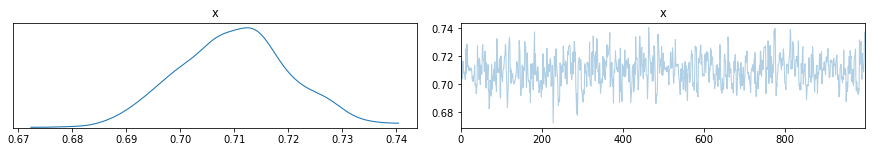

In [71]:
az.plot_trace(hmc_samples['p'])

array([<AxesSubplot:title={'center':'x'}>], dtype=object)

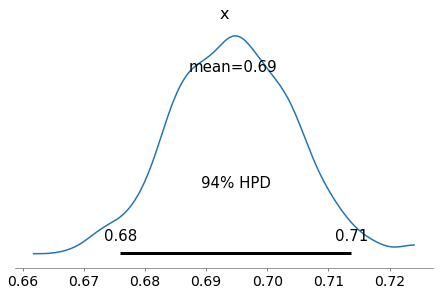

In [76]:
az.plot_posterior(hmc_samples['p'])

## Pyro and Variational inference

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

𝗐𝖾𝗂𝗀𝗁𝗍|𝗀𝗎𝖾𝗌𝗌∼𝖭𝗈𝗋𝗆𝖺𝗅(𝗀𝗎𝖾𝗌𝗌,1)
 
𝗆𝖾𝖺𝗌𝗎𝗋𝖾𝗆𝖾𝗇𝗍|𝗀𝗎𝖾𝗌𝗌,𝗐𝖾𝗂𝗀𝗁𝗍∼𝖭𝗈𝗋𝗆𝖺𝗅(𝗐𝖾𝗂𝗀𝗁𝗍,0.75)

In [9]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

(𝗐𝖾𝗂𝗀𝗁𝗍|𝗀𝗎𝖾𝗌𝗌,𝗆𝖾𝖺𝗌𝗎𝗋𝖾𝗆𝖾𝗇𝗍=9.5)∼?

In [10]:
conditioned_scale = pyro.condition(scale, data={"measurement": 5})

(array([  1.,   5.,  13.,  24.,  35.,  43.,  55.,  74., 112., 100., 128.,
        114.,  80.,  68.,  62.,  34.,  26.,  14.,  10.,   2.]),
 array([ 6.38768673,  6.74216113,  7.09663553,  7.45110993,  7.80558434,
         8.16005874,  8.51453314,  8.86900754,  9.22348194,  9.57795634,
         9.93243074, 10.28690515, 10.64137955, 10.99585395, 11.35032835,
        11.70480275, 12.05927715, 12.41375155, 12.76822596, 13.12270036,
        13.47717476]),
 <BarContainer object of 20 artists>)

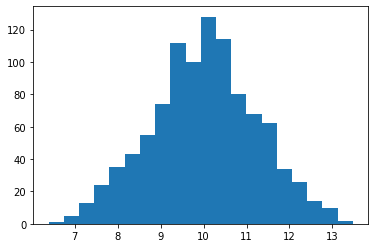

In [3]:
measurements = []
for _ in range(1000):
    measurements.append(scale(10).item())
plt.hist(measurements, bins=20)

In [90]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)

deferred_conditioned_scale(9.5,10)

9.5

In [5]:
def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [12]:
from torch.distributions import constraints
#build a generic guide

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs

In [14]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide_constrained,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

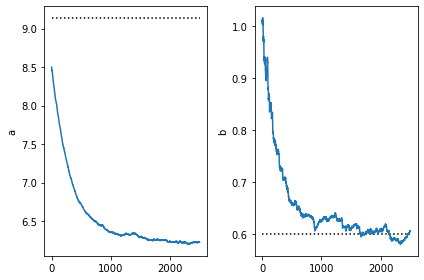

In [15]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

In [19]:
pyro.param("a").item()

6.228416919708252

In [20]:
pyro.sample("weight")

TypeError: sample() missing 1 required positional argument: 'fn'